## Mediation: Psychological Need Satisfaction → Epistemic Trust → Global AI Acceptance

We next test whether global psychological need satisfaction (TENS_Life_mean) is associated with
overall acceptance of AI mental-health technologies (UTAUT_AI_mean) indirectly through epistemic
trust in mental health technologies (ET_mean), while accounting for demographics, symptoms, stigma,
general AI attitudes, culture, and sample type.

Conceptually, this section evaluates a mediation pathway:

- **Predictor (X):** TENS_Life_mean_c – centered Self-Determination (need satisfaction in life)
- **Mediator (M):** ET_mean_c – centered epistemic trust in mental health technologies
- **Outcome (Y):** UTAUT_AI_mean – global AI acceptance for mental health interventions

We estimate:

1. **Path a:** X → M (Does need satisfaction relate to epistemic trust, net of covariates?)
2. **Paths b and c′:** M and X → Y (Does epistemic trust predict AI acceptance after accounting
   for need satisfaction, and is the direct effect of need satisfaction on AI acceptance still
   non-zero?)
3. **Indirect effect (a × b):** The product of a and b, with a non-parametric bootstrap to obtain a
   confidence interval for the mediated effect.

All predictors are either **mean-centered** (continuous variables) or entered as categorical
contrasts (gender, Country, role_label). We use listwise deletion within the mediation model.


# 0.0. Library and Path Setup

In [22]:
from __future__ import annotations

import warnings
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore", category=FutureWarning)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.size"] = 11

PROJECT_ROOT = Path.cwd().resolve()
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = DATA_DIR / "output"
PROCESSED_PATH = OUTPUT_DIR / "processed.csv"

processed = pd.read_csv(PROCESSED_PATH)

# 1.0. Define Mediation Sample & Center Variables (Imputed)

Uses imputed variables throughout

In [24]:
# Focal variables (imputed)
h4_vars_base = [
    # Outcome
    "UTAUT_AI_mean_imputed",
    # Predictor (X)
    "TENS_Life_mean_imputed",
    # Mediator (M)
    "ET_mean_imputed",
    # Covariates
    "age_imputed", "gender", "Country", "role_label",
    "PHQ5_mean_imputed", "SSRPH_mean_imputed", "GAAIS_mean_imputed",
]
missing_cols = [c for c in h4_vars_base if c not in processed.columns]

## 1.1. Center key continuous predictors for interpretability

In [26]:
for col in ["TENS_Life_mean_imputed", "ET_mean_imputed", "age_imputed"]:
    mean_val = processed[col].mean()
    processed[f"{col}_c"] = processed[col] - mean_val
    print(f"{col} mean for centering: {mean_val:.3f}")

TENS_Life_mean_imputed mean for centering: 4.774
ET_mean_imputed mean for centering: 4.253
age_imputed mean for centering: 34.465


In [27]:
# Build full mediation dataframe (including centered vars)
h4_vars_full = h4_vars_base + [
    "TENS_Life_mean_imputed_c",
    "ET_mean_imputed_c",
    "age_imputed_c",
]

h4_df_full = processed[h4_vars_full].dropna().copy()
print(f"H4 full-control mediation sample (listwise): N = {len(h4_df_full)}")

H4 full-control mediation sample (listwise): N = 2227


In [29]:
# Descriptives for mediation-relevant variables
print("Descriptives for mediation variables (imputed, centered where applicable):")
display(
    h4_df_full[
        ["TENS_Life_mean_imputed_c", "ET_mean_imputed_c", "UTAUT_AI_mean_imputed"]
    ].describe().T
)

Descriptives for mediation variables (imputed, centered where applicable):


,count,mean,std,min,25%,50%,75%,max
TENS_Life_mean_imputed_c,2227.0,-0.009868,0.998003,-3.774412,-0.663300,0.100588,0.725588,2.225588
ET_mean_imputed_c,2227.0,0.007612,0.840602,-3.253127,-0.586460,-0.119794,0.480206,2.746873
UTAUT_AI_mean_imputed,2227.0,4.780828,1.368618,1.115385,3.448718,5.000000,6.000000,7.814815


In [30]:
print("Pearson correlations among X (TENS), M (ET), Y (UTAUT_AI):")
display(
    h4_df_full[
        ["TENS_Life_mean_imputed_c", "ET_mean_imputed_c", "UTAUT_AI_mean_imputed"]
    ].corr()
)

Pearson correlations among X (TENS), M (ET), Y (UTAUT_AI):


,TENS_Life_mean_imputed_c,ET_mean_imputed_c,UTAUT_AI_mean_imputed
TENS_Life_mean_imputed_c,1.000000,-0.141239,0.156491
ET_mean_imputed_c,-0.141239,1.000000,0.045534
UTAUT_AI_mean_imputed,0.156491,0.045534,1.000000


# 2.0. Model Specification (Full-Control)

We first estimate the mediation pathway **controlling for the same covariates used in earlier hypothesis tests (H1–H3)** to keep the adjustment set consistent:

- **Covariates:** age_c, gender, PHQ5_mean (depressive symptoms),
  SSRPH_mean (self-stigma), GAAIS_mean (general AI attitudes),
  Country (China vs USA), and role_label (client vs therapist vs unknown).

Thus:

- **Path a model (X → M):**

  `ET_mean_imputed_c ~ TENS_Life_mean_imputed_c + age_imputed_c + C(gender) + PHQ5_mean_imputed + SSRPH_mean_imputed + GAAIS_mean_imputed + C(Country) + C(role_label)`

- **Path b + c′ model (M and X → Y):**

  `UTAUT_AI_mean_imputed ~ TENS_Life_mean_imputed_c + ET_mean_imputed_c + age_imputed_c + C(gender) + PHQ5_mean_imputed + SSRPH_mean_imputed + GAAIS_mean_imputed + C(Country) + C(role_label)`

We estimate these models with OLS using listwise deletion on the full set of variables.

## 2.1. Path a: X → M (TENS → ET), adjusting for full covariates

In [33]:
print(f"H4 full-control sample size (listwise): N = {len(h4_df_full)}")
a_model_full = smf.ols(
    formula=(
        "ET_mean_imputed_c ~ "
        "TENS_Life_mean_imputed_c "
        "+ age_imputed_c + C(gender) "
        "+ PHQ5_mean_imputed + SSRPH_mean_imputed + GAAIS_mean_imputed "
        "+ C(Country) + C(role_label)"
    ),
    data=h4_df_full,
).fit()

print("H4 Path a (TENS_Life_mean_imputed_c → ET_mean_imputed_c; full-control):")
display(a_model_full.summary().tables[1])

H4 full-control sample size (listwise): N = 2227
H4 Path a (TENS_Life_mean_imputed_c → ET_mean_imputed_c; full-control):


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.2404,0.127,-9.781,0.000,-1.489,-0.992
C(gender)[T.2.0],0.0159,0.032,0.491,0.623,-0.047,0.079
C(gender)[T.3.0],-0.0255,0.111,-0.229,0.819,-0.244,0.193
C(gender)[T.4.0],-0.3950,0.276,-1.430,0.153,-0.937,0.147
C(Country)[T.USA],0.0383,0.034,1.112,0.266,-0.029,0.106
C(role_label)[T.therapist],0.1029,0.067,1.542,0.123,-0.028,0.234
C(role_label)[T.unknown],0.0383,0.034,1.112,0.266,-0.029,0.106
TENS_Life_mean_imputed_c,-0.0250,0.017,-1.498,0.134,-0.058,0.008
age_imputed_c,-0.0055,0.001,-4.434,0.000,-0.008,-0.003
PHQ5_mean_imputed,0.2088,0.017,12.641,0.000,0.176,0.241


In [34]:
print(f"R² (Path a, full-control) = {a_model_full.rsquared:.3f}")

R² (Path a, full-control) = 0.253


TENS → ET: b ≈ −0.025, p ≈ .13 → not significant

Strong positive associations of ET with:
- PHQ5 (b ≈ 0.21, p < .001)
- SSRPH (b ≈ 0.28, p < .001)
- GAAIS (b ≈ 0.12, p < .001)

R² ≈ .25

Once we partial out symptoms, stigma, and general AI attitudes, there’s no clean residual link from need satisfaction to epistemic trust.

## 2.2. Paths b and c': M and X → Y, adjusting for same covariates

In [35]:
b_model_full = smf.ols(
    formula=(
        "UTAUT_AI_mean_imputed ~ "
        "TENS_Life_mean_imputed_c + ET_mean_imputed_c "
        "+ age_imputed_c + C(gender) "
        "+ PHQ5_mean_imputed + SSRPH_mean_imputed + GAAIS_mean_imputed "
        "+ C(Country) + C(role_label)"
    ),
    data=h4_df_full,
).fit()

print("H4 Paths b + c' (ET_mean_imputed_c and TENS_Life_mean_imputed_c → UTAUT_AI_mean_imputed; full-control):")
display(b_model_full.summary().tables[1])

H4 Paths b + c' (ET_mean_imputed_c and TENS_Life_mean_imputed_c → UTAUT_AI_mean_imputed; full-control):


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.7873,0.206,8.662,0.000,1.383,2.192
C(gender)[T.2.0],-0.0732,0.051,-1.423,0.155,-0.174,0.028
C(gender)[T.3.0],0.1121,0.177,0.632,0.528,-0.236,0.460
C(gender)[T.4.0],0.5995,0.440,1.362,0.173,-0.264,1.463
C(Country)[T.USA],1.0880,0.055,19.841,0.000,0.980,1.195
C(role_label)[T.therapist],0.0715,0.106,0.673,0.501,-0.137,0.280
C(role_label)[T.unknown],1.0880,0.055,19.841,0.000,0.980,1.195
TENS_Life_mean_imputed_c,0.0936,0.027,3.523,0.000,0.041,0.146
ET_mean_imputed_c,0.2054,0.034,6.070,0.000,0.139,0.272
age_imputed_c,-0.0206,0.002,-10.287,0.000,-0.024,-0.017


In [36]:
print(f"R² (Path b/c', full-control) = {b_model_full.rsquared:.3f}")

R² (Path b/c', full-control) = 0.285


ET → UTAUT (b-path): b ≈ 0.205, p < .001 → clear positive effect.

TENS → UTAUT (c′): b ≈ 0.094, p < .001 → small but solid positive direct effect.

Strong positive effect of:

- Country (USA vs China) ≈ 1.09, p < .001
- GAAIS (b ≈ 0.24, p < .001)
- R² ≈ .29

Indirect (full-control)
- a ≈ −0.025, b ≈ 0.205 → a×b ≈ −0.0051 → tiny, likely not practically meaningful.

Conclusion for full-control model

- Mediation is not supported in the classic “needs → trust → acceptance” sense.
- ET is a strong independent predictor of UTAUT.
- TENS has its own direct positive effect on UTAUT (controlling for ET, symptoms, stigma, GAAIS, Country, role).

# 3.0. Parsimonious Mediation Model (Demographics + Country Only)

### 3.1. Parsimonious mediation model

In [37]:
h4_vars_simple = [
    "UTAUT_AI_mean_imputed",
    "TENS_Life_mean_imputed_c",
    "ET_mean_imputed_c",
    "age_imputed_c",
    "gender",
    "Country",
]

h4_df_simple = processed[h4_vars_simple].dropna().copy()
print(f"H4 parsimonious mediation sample (listwise): N = {len(h4_df_simple)}")

H4 parsimonious mediation sample (listwise): N = 2227


### 3.2.  Path a (parsimonious): TENS → ET with minimal covariates

ET_mean_imputed_c ~ TENS_Life_mean_imputed_c + age_imputed_c + C(gender) + C(Country)

- TENS → ET: b ≈ −0.0579, p ≈ .001 → significant negative association.
- R² ≈ .10

In [38]:
a_model_simple = smf.ols(
    formula=(
        "ET_mean_imputed_c ~ "
        "TENS_Life_mean_imputed_c + age_imputed_c + C(gender) + C(Country)"
    ),
    data=h4_df_simple,
).fit()

print("H4 Path a (TENS_Life_mean_imputed_c → ET_mean_imputed_c; parsimonious):")
display(a_model_simple.summary().tables[1])

H4 Path a (TENS_Life_mean_imputed_c → ET_mean_imputed_c; parsimonious):


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2050,0.050,4.086,0.000,0.107,0.303
C(gender)[T.2.0],0.0675,0.035,1.938,0.053,-0.001,0.136
C(gender)[T.3.0],0.0413,0.122,0.338,0.735,-0.198,0.280
C(gender)[T.4.0],-0.3554,0.303,-1.172,0.241,-0.950,0.239
C(Country)[T.USA],-0.2935,0.056,-5.250,0.000,-0.403,-0.184
TENS_Life_mean_imputed_c,-0.0579,0.018,-3.293,0.001,-0.092,-0.023
age_imputed_c,-0.0081,0.001,-6.008,0.000,-0.011,-0.005


In [39]:
print(f"R² (Path a, parsimonious) = {a_model_simple.rsquared:.3f}")

R² (Path a, parsimonious) = 0.099


## 3.3. Path b + c': ET + TENS → UTAUT (parsimonious)

UTAUT_AI_mean_imputed ~ TENS_Life_mean_imputed_c + ET_mean_imputed_c + age_imputed_c + C(gender) + C(Country)

- ET → UTAUT: b ≈ 0.265, p < .001.
- TENS → UTAUT: b ≈ 0.128, p < .001.
- Country huge effect again (USA > China).

R² ≈ .27.

In [40]:
b_model_simple = smf.ols(
    formula=(
        "UTAUT_AI_mean_imputed ~ "
        "TENS_Life_mean_imputed_c + ET_mean_imputed_c "
        "+ age_imputed_c + C(gender) + C(Country)"
    ),
    data=h4_df_simple,
).fit()

print("H4 Paths b + c' (ET_mean_imputed_c and TENS_Life_mean_imputed_c → UTAUT_AI_mean_imputed; parsimonious):")
display(b_model_simple.summary().tables[1])

H4 Paths b + c' (ET_mean_imputed_c and TENS_Life_mean_imputed_c → UTAUT_AI_mean_imputed; parsimonious):


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.1445,0.074,42.475,0.000,2.999,3.290
C(gender)[T.2.0],-0.0286,0.051,-0.559,0.576,-0.129,0.072
C(gender)[T.3.0],0.1105,0.179,0.617,0.538,-0.241,0.462
C(gender)[T.4.0],0.5869,0.446,1.317,0.188,-0.287,1.461
C(Country)[T.USA],2.0939,0.083,25.323,0.000,1.932,2.256
TENS_Life_mean_imputed_c,0.1282,0.026,4.948,0.000,0.077,0.179
ET_mean_imputed_c,0.2652,0.031,8.499,0.000,0.204,0.326
age_imputed_c,-0.0201,0.002,-10.081,0.000,-0.024,-0.016


In [41]:
print(f"R² (Path b/c', parsimonious) = {b_model_simple.rsquared:.3f}")

R² (Path b/c', parsimonious) = 0.266


### 3.4. Point estimate of indirect effect

a ≈ −0.0579, b ≈ 0.2652 → a×b ≈ −0.0154.

In [42]:
a_coef_simple = a_model_simple.params.get("TENS_Life_mean_imputed_c", np.nan)
b_coef_simple = b_model_simple.params.get("ET_mean_imputed_c", np.nan)
cprime_simple = b_model_simple.params.get("TENS_Life_mean_imputed_c", np.nan)
indirect_simple_ab = a_coef_simple * b_coef_simple

In [43]:
print("Key parsimonious path estimates (using imputed variables):")
print(f"  a (TENS → ET | demo + Country)        = {a_coef_simple:.4f}")
print(f"  b (ET → UTAUT | TENS, demo + Country) = {b_coef_simple:.4f}")
print(f"  c' (TENS → UTAUT | ET, demo + Country)= {cprime_simple:.4f}")
print(f"  a × b (indirect, parsimonious)        = {indirect_simple_ab:.4f}")

Key parsimonious path estimates (using imputed variables):
  a (TENS → ET | demo + Country)        = -0.0579
  b (ET → UTAUT | TENS, demo + Country) = 0.2652
  c' (TENS → UTAUT | ET, demo + Country)= 0.1282
  a × b (indirect, parsimonious)        = -0.0154


## 3.5. Multicollinearity & diagnostics

Full-control model b-path includes: TENS, ET, PHQ5, SSRPH, GAAIS, age, gender, Country, role.

Everything is still VIF < ~4, we can comfortably say multicollinearity is not severe


In [ ]:
# VIFs for parsimonious H4 b-model
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = b_model_simple.model.exog
names = b_model_simple.model.exog_names

vif_rows = []
for i, name in enumerate(names):
    if name == "Intercept":
        continue
    vif_rows.append({
        "Predictor": name,
        "VIF": variance_inflation_factor(X, i)
    })

vif_h4_b = pd.DataFrame(vif_rows).sort_values("VIF", ascending=False)
display(vif_h4_b)

,Predictor,VIF
6,age_imputed_c,1.881762
3,C(Country)[T.USA],1.879381
5,ET_mean_imputed_c,1.109414
4,TENS_Life_mean_imputed_c,1.078727
0,C(gender)[T.2.0],1.040419
1,C(gender)[T.3.0],1.026195
2,C(gender)[T.4.0],1.004582


# 4.0. Bootstrap for Indirect Effect

## 4.1. Bootstrap for indirect effect a × b

Bootstrap:

mean ≈ −0.0155

95% CI ≈ [−0.0290, −0.0031] → CI excludes 0, but effect is small.

In [44]:
n_boot = 5000
boot_indirect = []
n = len(h4_df_simple)

rng = np.random.default_rng(seed=42)  # reproducible

for _ in range(n_boot):
    sample_idx = rng.integers(0, n, size=n)
    sample = h4_df_simple.iloc[sample_idx]

    # Path a in bootstrap sample
    a_m = smf.ols(
        formula=(
            "ET_mean_imputed_c ~ "
            "TENS_Life_mean_imputed_c + age_imputed_c + C(gender) + C(Country)"
        ),
        data=sample,
    ).fit()

    # Path b + c' in bootstrap sample
    b_m = smf.ols(
        formula=(
            "UTAUT_AI_mean_imputed ~ "
            "TENS_Life_mean_imputed_c + ET_mean_imputed_c "
            "+ age_imputed_c + C(gender) + C(Country)"
        ),
        data=sample,
    ).fit()

    a_b = a_m.params.get("TENS_Life_mean_imputed_c", np.nan)
    b_b = b_m.params.get("ET_mean_imputed_c", np.nan)

    if not np.isnan(a_b) and not np.isnan(b_b):
        boot_indirect.append(a_b * b_b)

boot_indirect = np.array(boot_indirect)
indirect_mean = np.mean(boot_indirect)
ci_lower, ci_upper = np.percentile(boot_indirect, [2.5, 97.5])

In [45]:
print("Bootstrapped indirect effect (parsimonious a × b):")
print(f"  Mean indirect effect = {indirect_mean:.4f}")
print(f"  95% CI               = [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"  Successful bootstraps: {len(boot_indirect)} / {n_boot}")

Bootstrapped indirect effect (parsimonious a × b):
  Mean indirect effect = -0.0155
  95% CI               = [-0.0290, -0.0031]
  Successful bootstraps: 5000 / 5000


Clear suppression / inconsistent mediation:

- TENS directly increases UTAUT.
- TENS is (slightly) associated with lower ET.
- ET strongly increases UTAUT.

Therefore the indirect effect is small and negative, slightly reducing the overall positive relationship between TENS and UTAUT.

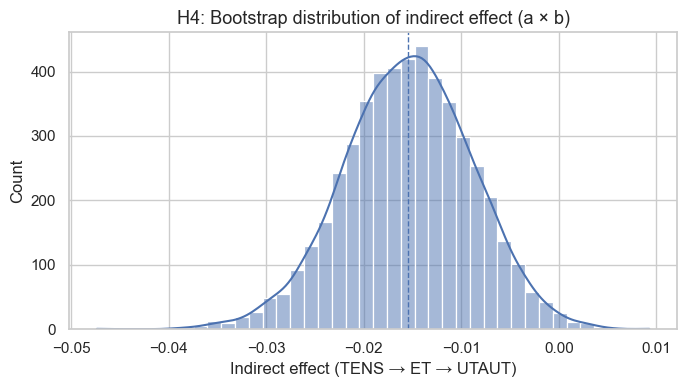

In [46]:
# Visualize distribution of bootstrap indirect effects
plt.figure(figsize=(7, 4))
sns.histplot(boot_indirect, bins=40, kde=True)
plt.axvline(indirect_mean, linestyle="--", linewidth=1)
plt.title("H4: Bootstrap distribution of indirect effect (a × b)")
plt.xlabel("Indirect effect (TENS → ET → UTAUT)")
plt.tight_layout()
plt.show()

# Narrative Summary

In [ ]:
summary_rows = []

# Safely extract coefficients from full-control models
if "a_model_full" in globals() and "b_model_full" in globals():
    a_coef_full = a_model_full.params.get("TENS_Life_mean_imputed_c", np.nan)
    b_coef_full = b_model_full.params.get("ET_mean_imputed_c", np.nan)
    cprime_full = b_model_full.params.get("TENS_Life_mean_imputed_c", np.nan)
    indirect_full_ab = a_coef_full * b_coef_full

    summary_rows.append({
        "Model": "Full-control",
        "a (TENS→ET)": a_coef_full,
        "b (ET→UTAUT)": b_coef_full,
        "c' (TENS→UTAUT)": cprime_full,
        "a×b (indirect)": indirect_full_ab,
        "Boot a×b mean": np.nan,
        "Boot a×b CI_low": np.nan,
        "Boot a×b CI_high": np.nan,
    })
else:
    print("Warning: a_model_full / b_model_full not found; skipping full-control row.")

# Safely extract coefficients from parsimonious models
if "a_model_simple" in globals() and "b_model_simple" in globals():
    a_coef_simple = a_model_simple.params.get("TENS_Life_mean_imputed_c", np.nan)
    b_coef_simple = b_model_simple.params.get("ET_mean_imputed_c", np.nan)
    cprime_simple = b_model_simple.params.get("TENS_Life_mean_imputed_c", np.nan)
    indirect_simple_ab = a_coef_simple * b_coef_simple

    summary_rows.append({
        "Model": "Parsimonious",
        "a (TENS→ET)": a_coef_simple,
        "b (ET→UTAUT)": b_coef_simple,
        "c' (TENS→UTAUT)": cprime_simple,
        "a×b (indirect)": indirect_simple_ab,
        "Boot a×b mean": indirect_mean,
            # indirect_mean, ci_lower, ci_upper should come from the bootstrap cell
        "Boot a×b CI_low": ci_lower,
        "Boot a×b CI_high": ci_upper,
    })
else:
    print("Warning: a_model_simple / b_model_simple not found; skipping parsimonious row.")

h4_summary_table = pd.DataFrame(summary_rows)
print("H4 mediation summary (imputed, processed dataset):")
display(h4_summary_table)

H4 mediation summary (imputed, processed dataset):


,Model,a (TENS→ET),b (ET→UTAUT),c' (TENS→UTAUT),a×b (indirect),Boot a×b mean,Boot a×b CI_low,Boot a×b CI_high
0,Full-control,-0.024976,0.205430,0.093586,-0.005131,NaN,NaN,NaN
1,Parsimonious,-0.057899,0.265183,0.128208,-0.015354,-0.015482,-0.02895,-0.003117
